## El hundimiento del Titanic

El hundimiento del Titanic es uno de los naufragios más famosos de la historia.

El 15 de abril de 1912, durante su viaje inaugural, el navío se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de 2224 pasajeros y tripulantes.

Si bien hubo algún elemento de suerte involucrado en la supervivencia, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

# Datos 

Se tienen un total de  1309 instancias de pasajeros, cada uno con 11 columnas entre las que se encuentran: el nombre, el sexo, la edad, la cabina, el puerto en el que embarcaron, etc. 

Se trata de una competición a modo introductorio en la comunidad **Kaggle**, se tienen de entrada los sets de entrenamiento y testeo separados. El objetivo final es obtener las predicciones de los pasajeros que sobreviven en el test y subir los resultados para la evaluación por parte de la plataforma.

Esta base de datos puede obtenerse de la página oficial de Kaggle, desde el siguiente enlace: https://www.kaggle.com/c/titanic/data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import expon,norm
%matplotlib inline

In [2]:
titanic_df=pd.read_csv('datasets/titanic/train.csv')

In [3]:
test_df=pd.read_csv('datasets/titanic/test.csv')

Obtenemos un resumen sobre sobre ambos subsets para ver las columnas que hay, los tipos de datos que presenta cada una, y los valores nulos.

Borramos además la columna del id de cada uno de los sets ya que no nos ofrece ningún tipo de valor a la hora de generar nuestro modelo. No obstante guardamos la perteneciente al test, ya que la necesitaremos en caso de querer subir nuestras predicciones a la plataforma Kaggle.

In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
titanic_df.drop(columns=['PassengerId'], inplace=True)
PassengerIdTest=test_df['PassengerId']
test_df.drop(columns=['PassengerId'], inplace=True)

Las variables predictoras no presentan practicamente correlacion entre ellas, y tampoco con la la variable objetivo **Survived**.

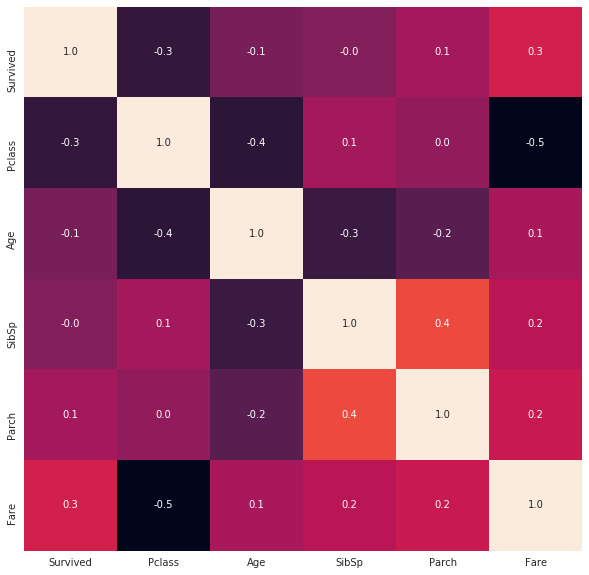

In [7]:
figure=plt.figure(figsize=(10,10))
g1=sns.heatmap(titanic_df.corr(), annot=True, fmt='.1f', cbar=False)

Vamos a ir visualizando, estudiando y tratando cada una de las variables, a ver que podemos sacar de ellas.

En los dos siguientes grafos, mostramos la cantidad de pasajeros perteneciente a cada clase de pasajero junto con la proporción de pasajeros que sobreviven en cada una de ellas.

Los resultados observados son los esperados. El tipo de pasajero más común es el de clase 3, que parece ser el que más probabilidades tiene de morir.

Mediante el método **get_dummies** de **Pandas**, realizamos un *one-hot encoding* de la variable categórica Pclass. Además descartamos una de las columnas para evitar la **trampa de la variable ficticia** (*dummy variable trap*).

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


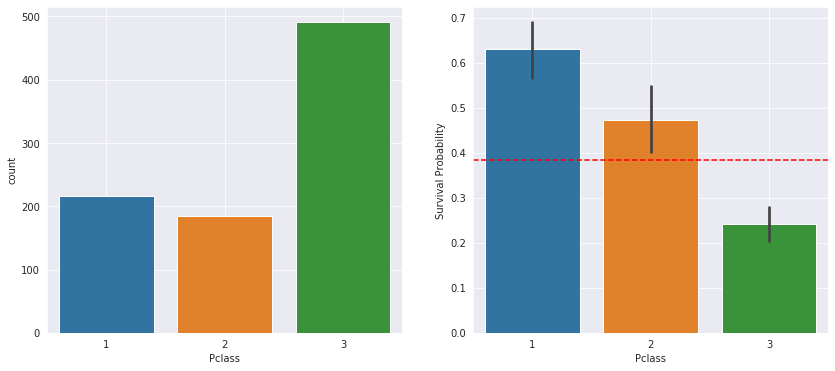

In [8]:
figure,ax=plt.subplots(1,2,figsize=(14,6))
g1=sns.countplot(x='Pclass', data=titanic_df, ax=ax[0])
ax[0].grid(True)
g2=sns.factorplot(x='Pclass', y='Survived', data=titanic_df, kind='bar', ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df['Survived'].describe()['mean'], ls='--', color='r')
ax[1].grid(True)
plt.close(2)


In [9]:
titanic_df=pd.get_dummies(titanic_df, columns=['Pclass'], drop_first=True)

Pasamos a estudiar la varible *Name* de tipo cadena de texto. Él único valor que podemos sacar de la misma, es extrar el **título** de cada uno de los pasajeros y estudiar si tiene algún peso clasificador.

In [10]:
titanic_df['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [11]:
def get_title_from_names(name):
    return name.split(',')[1].split('.')[0].strip()

In [12]:
titanic_df['Title']=titanic_df['Name'].apply(get_title_from_names)

Vamos a quedarnos exclusivamente con los títulos que presesentan más de 6 instancias, el resto los agrupamos todos en una variable nueva que vamos a llamar **RareTitle**. 

Posteriormente generamos los grafos de manera análoga al caso anterior y, por último, realizamos el *one-hot encoding* de la misma forma. En este caso, aún no descartamos ninguna de las columnas generadas, vamos a esperar al final para elegir la que más interese, atendiendo a la correlación que pueda presentar con el resto. 

Parece ser que los tulos *Mrs* y *Miss* presentan las probabilidades más altas de supervivencia.

In [13]:
titanic_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Don               1
Capt              1
Lady              1
Mme               1
Ms                1
Jonkheer          1
Sir               1
the Countess      1
Name: Title, dtype: int64

In [14]:
titanic_df['Title'].replace(['Col','Major','Jonkheer','Ms','Mlle','Mme','Lady','Dona','the Countess','Sir','Capt','Don'],'RareTitle', inplace=True)

In [15]:
titanic_df.drop(columns=['Name'], inplace=True)


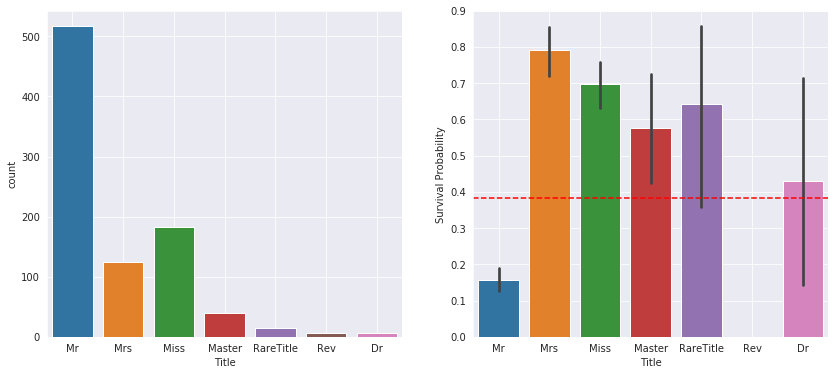

In [16]:
figure, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Title', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Title', y='Survived', kind='bar',data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability')
ax[1].axhline(titanic_df['Survived'].describe()['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

In [17]:
titanic_df=pd.get_dummies(titanic_df, columns=['Title'])
titanic_df.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareTitle,Title_Rev
0,0,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,0,0,0,1,0,0
2,1,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,0,0,0,1,0,0
4,0,male,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,0,1,0,0,0


In [18]:
titanic_df.describe()

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareTitle,Title_Rev
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208,0.206510,0.551066,0.007856,0.044893,0.204265,0.580247,0.140292,0.015713,0.006734
std,0.486592,14.526497,1.102743,0.806057,49.693429,0.405028,0.497665,0.088337,0.207186,0.403390,0.493796,0.347485,0.124431,0.081830
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Pasamos a la variable sexo, simplemente mostramos los mismos grafos y realizamos la transformación de la variable.

Según lo que vemos, las mujeres sobreviven mucho más que los hombres, hecho que ya podíamos ver en la anterios varible *Title*

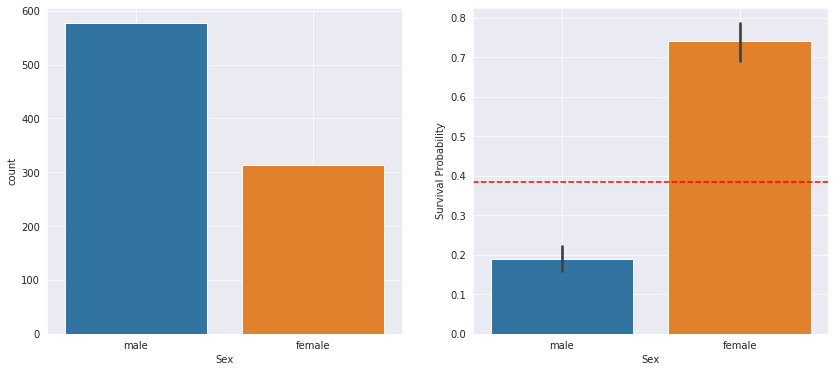

In [19]:
figure, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Sex', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Sex', y='Survived', kind='bar',data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability')
ax[1].axhline(titanic_df['Survived'].describe()['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

In [20]:
titanic_df=pd.get_dummies(titanic_df, columns=['Sex'],drop_first=True)

In [21]:
titanic_df.head()

,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareTitle,Title_Rev,Sex_male
0,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,0,0,1,0,0,0,1
1,1,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,0,0,0,1,0,0,0
2,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,1,0,0,0,0,0
3,1,35.0,1,0,113803,53.1000,C123,S,0,0,0,0,0,0,1,0,0,0
4,0,35.0,0,0,373450,8.0500,NaN,S,0,1,0,0,0,1,0,0,0,1


Nos toca la variable edad. Esta variable requiere algo de procesado. En primer lugar hay que hacere cargo de todas las filas que presentan un valor null. Para ello creamos una función, *generate_new_age*, que genera un valor aleatorio dentro de un rango marcado por edades que existen en la base de datos.

Posteriormente, para reducir el número de posibles valores, vamos a hacer una agrupación de los mismos. Obtenemos entonces una variable categórica que debemos nuevamente codificar.

In [22]:
titanic_df['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [23]:
titanic_df['Age'].isnull().sum()

177

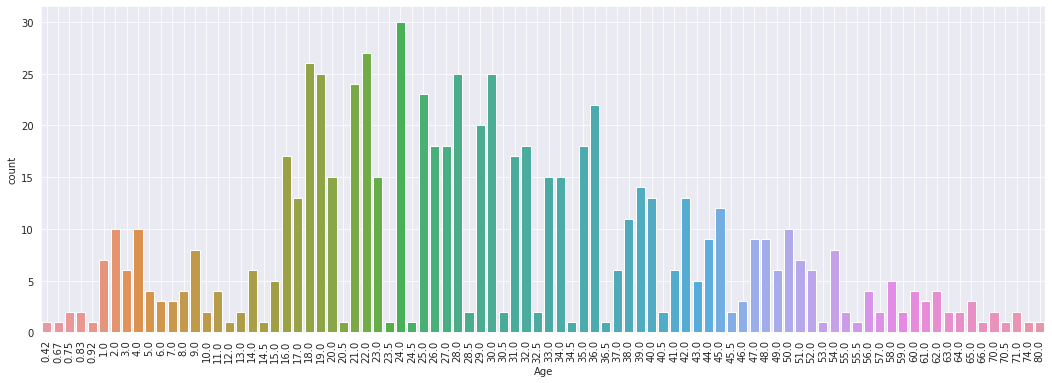

In [24]:
figure=plt.figure(figsize=(18,6))
g=sns.countplot(x='Age', data=titanic_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.grid(True)


In [25]:
ages=titanic_df[titanic_df['Age'].notnull()]['Age'].values

In [26]:
def generate_new_age(null):
    return float(np.random.choice(ages, 1))


In [27]:
titanic_df['Age']=titanic_df['Age'].isnull().apply(generate_new_age)

In [28]:
def group_ages(age):
    return (age//5)

In [29]:
titanic_df['Age_Gr']=titanic_df['Age'].apply(group_ages)

In [30]:
titanic_df['Age_Gr'].value_counts()

4.0     145
6.0     131
5.0     131
3.0     118
7.0      98
8.0      53
9.0      49
0.0      38
10.0     38
1.0      28
11.0     21
2.0      15
12.0     12
14.0     10
13.0      4
Name: Age_Gr, dtype: int64

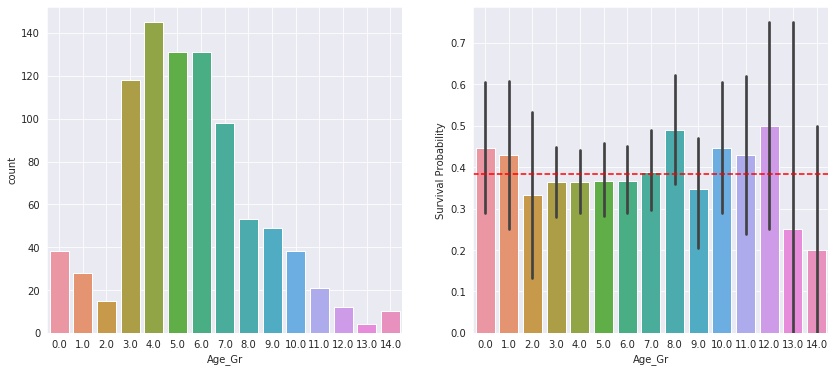

In [31]:
figure, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Age_Gr', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Age_Gr', y='Survived', kind='bar',data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df['Survived'].describe()['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

In [32]:
titanic_df.drop(columns=['Age'], inplace=True)
titanic_df=pd.get_dummies(titanic_df, columns=['Age_Gr'],drop_first=True)
titanic_df.head()

,Survived,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_2,Pclass_3,Title_Dr,...,Age_Gr_5.0,Age_Gr_6.0,Age_Gr_7.0,Age_Gr_8.0,Age_Gr_9.0,Age_Gr_10.0,Age_Gr_11.0,Age_Gr_12.0,Age_Gr_13.0,Age_Gr_14.0
0,0,1,0,A/5 21171,7.2500,NaN,S,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,PC 17599,71.2833,C85,C,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,113803,53.1000,C123,S,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,373450,8.0500,NaN,S,0,1,0,...,0,0,0,1,0,0,0,0,0,0


Es turno de las dos variables que presentan menor correlación con la variable objetivo: **SibSp** y **Parch**.

La primera hace referencia al número de hermanos o cónyugues del pasajero, y la segunda al número de padres o hijos.

Vamos a probar a generar una nueva variable que refleje simplemente si el **pasajero viajaba solo o no**. Para ello creamos una funcion, *travels_alone*, que suma los valores de estas dos variables y devuelve un booleano reflejando esta condición.

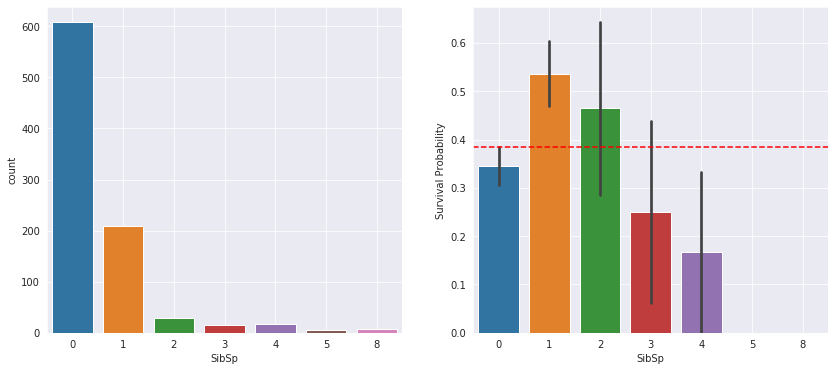

In [33]:
fig, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='SibSp', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='SibSp', y='Survived', kind='bar', data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df.describe()['Survived']['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

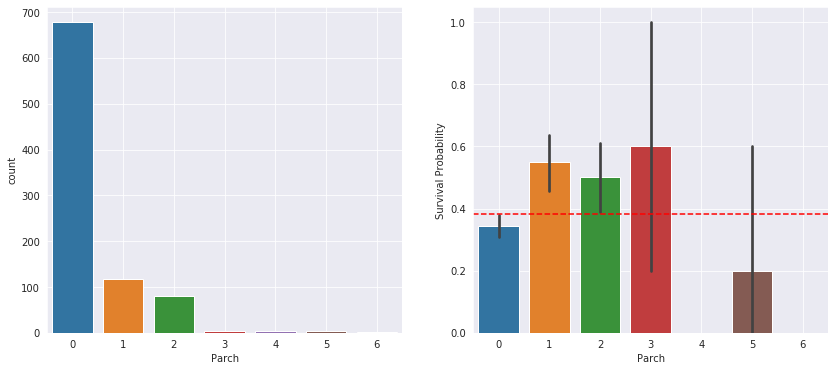

In [34]:
fig, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Parch', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Parch', y='Survived', kind='bar', data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df.describe()['Survived']['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

In [35]:
def travels_alone(row):
    return int(row['SibSp']+row['Parch'])==0

In [36]:
titanic_df['Tr_Alone']=titanic_df.apply(travels_alone, axis=1)

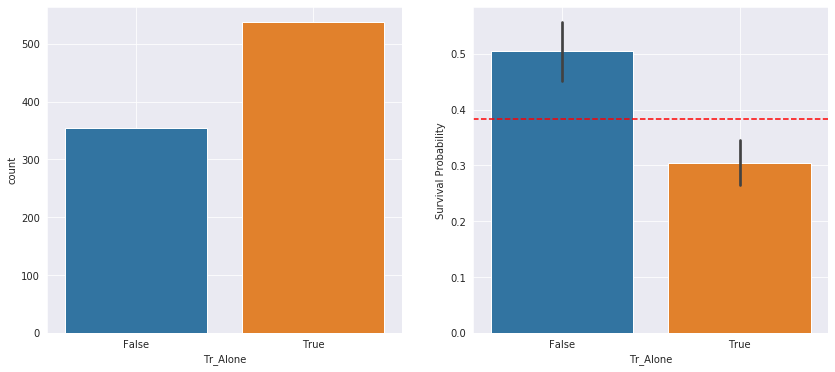

In [37]:
fig, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Tr_Alone', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Tr_Alone', y='Survived', kind='bar', data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df.describe()['Survived']['mean'], ls='--', color='r')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

In [38]:
print(titanic_df.corr()['Survived']['Tr_Alone'])

-0.2033670856998897


Parece ser que la nueva variable nos aporta mucha más información para clasificar pasajeros que las otras dos, luego seguimos para adelante borrando la dos originales y haciendo una codificación de la nueva variable.

In [39]:
titanic_df.drop(columns=['SibSp', 'Parch'], inplace=True)
titanic_df=pd.get_dummies(titanic_df, columns=['Tr_Alone'], drop_first=True)

Pasamos a la variable **Ticket**. Es una variable algo complicada, vamos a tratar de sacar algún tipo de información enfocándonos en las letras de los billetes.

In [40]:
titanic_df['Ticket'].value_counts()

CA. 2343      7
1601          7
347082        7
CA 2144       6
3101295       6
             ..
349231        1
A/S 2816      1
A/4. 34244    1
250648        1
211536        1
Name: Ticket, Length: 681, dtype: int64

In [41]:
ticket_w_letter=titanic_df.loc[titanic_df['Ticket'].str.contains('[a-zA-Z]', regex=True)]
ticket_wout_letter=titanic_df.loc[~titanic_df['Ticket'].str.contains('[a-zA-Z]', regex=True)]

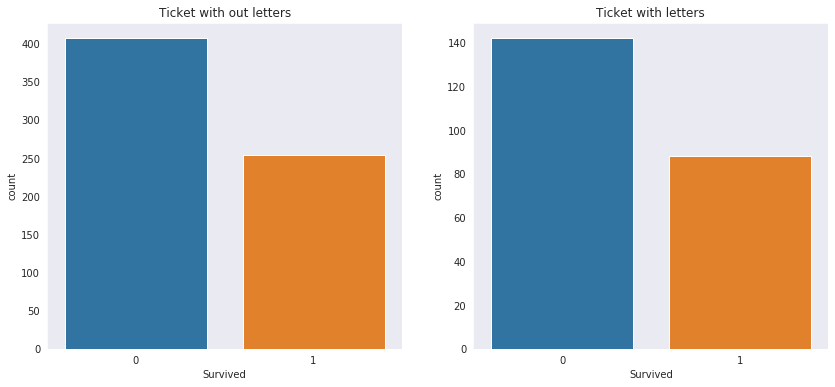

In [42]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
g1=sns.countplot(x='Survived', data=ticket_wout_letter,ax=ax[0])
ax[0].set_title('Ticket with out letters')
g1=sns.countplot(x='Survived', data=ticket_w_letter, ax=ax[1])
ax[1].set_title('Ticket with letters')
plt.close(2)


Mostramos en un histograma aquellos billetes que presentan letras. Vemos que existen algunos patrones que se repiten, aunque probablemente puedan hacer refencia al puerto en el que embarcaba el pasajero en cuestión (información que ya tenemos en otra variable).

Veamos la relación de supervivencia con aquellos billetes que presenten *PC* y *W./C.*:

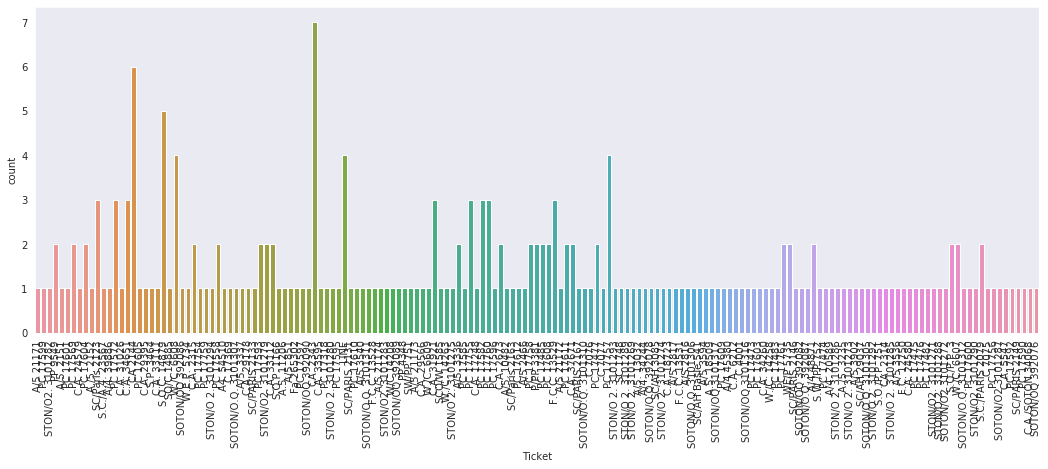

In [43]:
figure=plt.figure(figsize=(18,6))
g=sns.countplot(x='Ticket', data=ticket_w_letter)
g.set_xticklabels(g.get_xticklabels(), rotation=90);


In [44]:
titanic_df.loc[titanic_df['Ticket'].str.contains('PC', regex=True),'Survived'].value_counts()

1    39
0    21
Name: Survived, dtype: int64

In [45]:
titanic_df.loc[titanic_df['Ticket'].str.contains('W./C.', regex=True),'Survived'].value_counts()

0    8
1    1
Name: Survived, dtype: int64

Parece ser que estas condicione podrían ayudarnos a clasificar pasajeros, luego vamos a crear dos funciones que nos ayuden a procesar las nuevas variables, las vamos posteriormente a codificar y vamos a descartar la variable original.

In [46]:
def pc_in_ticket(ticket):
    if re.search('PC', ticket):
        return True
    else:
        return False

def wc_in_ticket(ticket):
    if re.search('W./C.', ticket):
        return True
    else:
        return False

In [47]:
titanic_df['PC_inticket']=titanic_df['Ticket'].apply(pc_in_ticket)
titanic_df['WC_inticket']=titanic_df['Ticket'].apply(wc_in_ticket)

In [48]:
titanic_df=pd.get_dummies(titanic_df, columns=['PC_inticket', 'WC_inticket'], drop_first=True)

In [49]:
titanic_df.drop(columns=['Ticket'], inplace=True)

Pasamos ahora a la variable **Fare** que hace referencia a la tarifa del viaje del pasajero. Generamos un histograma para visualizar la distribución de la misma. 

Vamos a realizar una **discretización** de la variable usando la funcion **qcut** de Pandas. Esta función permite hacer agrupaciones basandose en los cuantiles. La idea es obtener intervalos que más o menos contengan la misma cantidad de instancias.

In [110]:
figure=plt.figure(figsize=(18,6))
g1=sns.countplot(titanic_df['Fare'].astype(np.int32))


KeyError: 'Fare'

<Figure size 1296x432 with 0 Axes>

In [51]:
most_frequent_fare=np.argmax(titanic_df['Fare'].value_counts())

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


In [52]:
most_frequent_fare

8.05

In [53]:
titanic_df['Fare_Gr']=pd.qcut(titanic_df['Fare'].astype(np.int32),7, precision=1)

In [54]:
titanic_df['Fare_Gr'].value_counts()

(-0.1, 7.0]      241
(12.0, 19.0]     129
(56.0, 512.0]    127
(27.0, 56.0]     125
(19.0, 27.0]     124
(8.0, 12.0]       75
(7.0, 8.0]        70
Name: Fare_Gr, dtype: int64

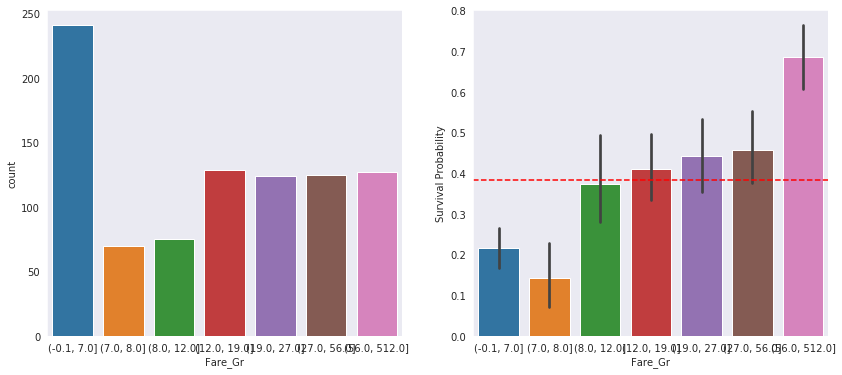

In [55]:
fig, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Fare_Gr', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Fare_Gr', y='Survived', kind='bar', data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df.describe()['Survived']['mean'], ls='--', color='r')
plt.close(2)

Descartamos la variable **Cabin** por la gran cantidad de valores null que tiene y, pasamos a **Embarked**.

Esta variable también presenta valores null, aunque son solo dos. Vamos a completarlos utilizando el **valor más frecuente**.

Posteriormente codificamos la variable categórical nominal como hemos venido haciendo durante la resolución del problema.

In [56]:
titanic_df.drop(columns=['Fare', 'Cabin'], inplace=True)
titanic_df=pd.get_dummies(titanic_df, columns=['Fare_Gr'],drop_first=True)

In [57]:
titanic_df['Embarked'].fillna(np.argmax(titanic_df['Embarked'].value_counts()), inplace=True)

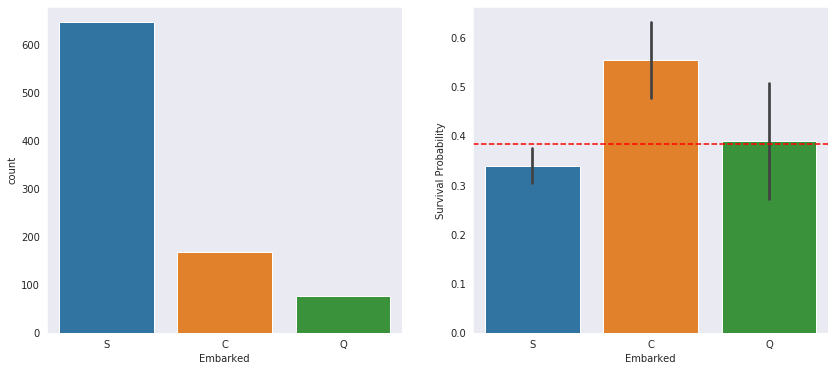

In [58]:
fig, ax=plt.subplots(1,2, figsize=(14,6))
g1=sns.countplot(x='Embarked', data=titanic_df, ax=ax[0])
g2=sns.factorplot(x='Embarked', y='Survived', kind='bar', data=titanic_df, ax=ax[1])
ax[1].set_ylabel('Survival Probability');
ax[1].axhline(titanic_df.describe()['Survived']['mean'], ls='--', color='r')
plt.close(2)

In [59]:
titanic_df = pd.get_dummies(titanic_df, columns=['Embarked'],drop_first=True)
titanic_df.head()



,Survived,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareTitle,Title_Rev,...,PC_inticket_True,WC_inticket_True,"Fare_Gr_(7.0, 8.0]","Fare_Gr_(8.0, 12.0]","Fare_Gr_(12.0, 19.0]","Fare_Gr_(19.0, 27.0]","Fare_Gr_(27.0, 56.0]","Fare_Gr_(56.0, 512.0]",Embarked_Q,Embarked_S
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Una vez tratadas todas las variables, vamos a ver como ha quedado la matriz de correlación a través de un mapa de calor.

La variable **Title_Mr** esta muy correlada con la variable **Sex_Male**. Si os acordais, aún no hemos descartado ninguna de la columnas de la variable codificada **Title**, entonces vamos a descartar evidentenemente **Title_Mr**.

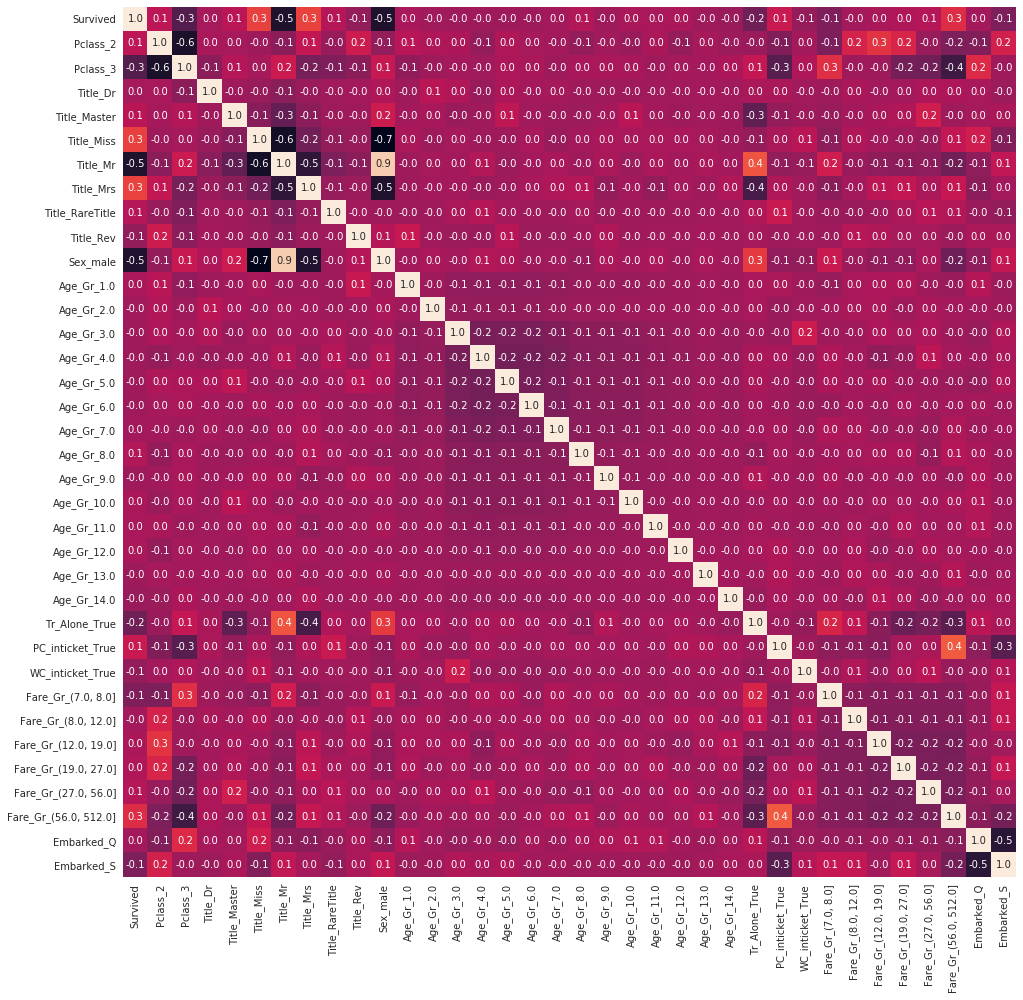

In [60]:
figure=plt.figure(figsize=(16,16))
g1=sns.heatmap(titanic_df.corr(), annot=True, fmt='.1f', cbar=False)

In [61]:
X_train=titanic_df.drop(columns=['Survived','Title_Mr'])
y_train=titanic_df['Survived']


In [62]:
titanic_df.head()

,Survived,Pclass_2,Pclass_3,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareTitle,Title_Rev,...,PC_inticket_True,WC_inticket_True,"Fare_Gr_(7.0, 8.0]","Fare_Gr_(8.0, 12.0]","Fare_Gr_(12.0, 19.0]","Fare_Gr_(19.0, 27.0]","Fare_Gr_(27.0, 56.0]","Fare_Gr_(56.0, 512.0]",Embarked_Q,Embarked_S
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Es momento de empezar a entrenar y realizar el ajuste de los clasificadore que vamos a utilizar para nuestro método embebido por votación.

Veamos cuales son los resultados:

In [63]:
param_dist_logistic={'solver':['newton-cg', 'liblinear','lbfgs', 'sag', 'saga'], 'penalty':['l2'], 'C':expon(scale=1)}
logistic_regressor=LogisticRegression()
rs_logistic=RandomizedSearchCV(logistic_regressor, param_distributions=param_dist_logistic, n_jobs=-1, cv=5, n_iter=250, scoring='accuracy')
rs_logistic.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=250, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f48af806b00>,
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'liblinear',
                    

In [64]:
rs_logistic.best_score_

0.8092031425364759

In [65]:
DTC=DecisionTreeClassifier(max_depth=1)
adaDTC=AdaBoostClassifier(DTC, random_state=0)
param_dist_ada = {'base_estimator__criterion':['gini', 'entropy'],
                  'base_estimator__splitter' :['best', 'random'],
                  'algorithm'                :['SAMME', 'SAMME.R'],
                  'n_estimators'             :[100,200,300,500],
                  'learning_rate'            :expon(scale=1)}
rs_ada=RandomizedSearchCV(adaDTC, param_distributions=param_dist_ada, n_jobs=-1, cv=5, n_iter=250, scoring='accuracy')
rs_ada.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=1,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                                                                      min_samples_leaf=1,
                       

In [66]:
rs_ada.best_score_

0.8058361391694725

In [67]:
param_dist_rf={'max_depth'        :  [4,5,6,7,8],
                 'max_features'     :[8,9,10,11],
                 'min_samples_split':[10],
                 'bootstrap'        :[False],
                 'n_estimators'     :[100,100,200,300],
                 'criterion'        :['gini', 'entropy']}
RFC=RandomForestClassifier()
rs_rf=RandomizedSearchCV(RFC, param_distributions=param_dist_rf, scoring='accuracy', n_jobs=-1, cv=5, n_iter=250 )
rs_rf.fit(X_train, y_train)

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 160 is smaller than n_iter=250. Running 160 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [68]:
rs_rf.best_score_

0.8159371492704826

In [69]:
param_dist_knc={'n_neighbors':[4,5,5,6,6,7], 'weights':['uniform', 'distance'], 'p':[1,2]}
KNC=KNeighborsClassifier()
rs_knc=RandomizedSearchCV(KNC, param_distributions=param_dist_knc, n_iter=250, n_jobs=-1, cv=5, scoring='accuracy')
rs_knc.fit(X_train, y_train)

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 24 is smaller than n_iter=250. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=250, n_jobs=-1,
                   param_distributions={'n_neighbors': [4, 5, 5, 6, 6, 7],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [70]:
rs_knc.best_score_

0.7833894500561167

In [71]:
param_dist_nn={'activation':['logistic', 'relu', 'tanh'], 'solver':['lbfgs', 'sgd', 'adam'], 'alpha':expon(scale=0.2), 'learning_rate_init':expon(scale=0.2)}
nn=MLPClassifier()
rs_nn=RandomizedSearchCV(nn, param_distributions=param_dist_nn, n_jobs=-1, n_iter=250, cv=5, scoring='accuracy')
rs_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rand...
                   param_distributions={'activation': ['logistic', 'relu',
                                                       'tanh'],
                                        '

In [72]:
rs_nn.best_score_

0.813692480359147

In [73]:
param_dist_svc={'C':expon(scale=1), 'kernel':['rbf', 'poly', 'sigmoid'], 'degree':[2,3,4,5,6], 'coef0':expon(scale=0.01)}
svc=SVC()
rs_svc=RandomizedSearchCV(svc, param_distributions=param_dist_svc, n_jobs=-1, n_iter=250, scoring='accuracy', cv=5)
rs_svc.fit(X_train, y_train)

/home/ignacio/MLbook/env_ml/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=250, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f48afa06be0>,
                                        'coef0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f48afa06518>,
                                        'degree': [2, 3, 4, 5, 6],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
    

In [74]:
rs_svc.best_score_

0.8159371492704826

In [75]:
param_dist_gaussian={'var_smoothing':expon(scale=0.001)}
gaussian=GaussianNB()
rs_gaussian=RandomizedSearchCV(gaussian, param_distributions=param_dist_gaussian, n_jobs=-1, scoring='accuracy', cv=5, n_iter=250)
rs_gaussian.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                   iid='warn', n_iter=250, n_jobs=-1,
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f48afce8710>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=0)

In [76]:
rs_gaussian.best_score_

0.734006734006734

In [77]:
classifiers=[LogisticRegression(**rs_logistic.best_params_),
             AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',splitter='best'),n_estimators= 200,learning_rate=0.47560685124037505,algorithm= 'SAMME.R'),
             RandomForestClassifier(**rs_rf.best_params_),
             KNeighborsClassifier(**rs_knc.best_params_),
             MLPClassifier(**rs_nn.best_params_),
             SVC(**rs_svc.best_params_),
             GaussianNB(**rs_gaussian.best_params_)]
scores=[]
for classifier in classifiers:
    scores.append(cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy'))

In [78]:
accuracy_mean=[]
accuracy_std=[]
for score in scores:
    accuracy_mean.append(np.mean(score))
    accuracy_std.append(np.std(score))

La media de los valores de precisión de lo clasificadores es 0.7924
La media de los valores de variación estándar de lo clasificadores es 0.0164


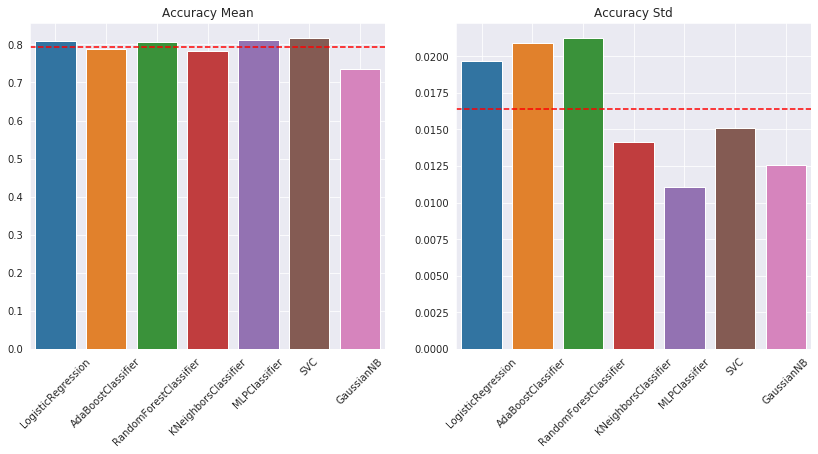

In [112]:
print(f'La media de los valores de precisión de lo clasificadores es {np.array(accuracy_mean).mean():.4f}')
print(f'La media de los valores de variación estándar de lo clasificadores es {np.array(accuracy_std).mean():.4f}')

classifier_names=['LogisticRegression','AdaBoostClassifier','RandomForestClassifier','KNeighborsClassifier','MLPClassifier','SVC','GaussianNB']
figure, ax=plt.subplots(1,2,figsize=(14,6))
g1=sns.barplot(x=classifier_names, y=accuracy_mean, ax=ax[0])
ax[0].set_title('Accuracy Mean');
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45);
g2=sns.barplot(x=classifier_names, y=accuracy_std, ax=ax[1])
ax[1].set_title('Accuracy Std')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45);
ax[0].axhline(np.array(accuracy_mean).mean(), color='red', ls='--')
ax[1].axhline(np.array(accuracy_std).mean(), color='red', ls='--')
ax[0].grid(True)
ax[1].grid(True)
plt.close(2)

Habiendo entrenado ya los estimadores, vamos a entrenar el método ensamblado por **hard voting** a ver si mejora lo que tenemos hasta ahora_

In [80]:
votingC = VotingClassifier(estimators = [('lr',LogisticRegression(**rs_logistic.best_params_)),
                                         ('ada', AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',splitter='best'),n_estimators= 200,learning_rate=0.47560685124037505,algorithm= 'SAMME.R')),
                                         ('rf',RandomForestClassifier(**rs_rf.best_params_)),
                                         ('knc',KNeighborsClassifier(**rs_knc.best_params_)),
                                         ('nn',MLPClassifier(**rs_nn.best_params_)),
                                         ('svc',SVC(**rs_svc.best_params_)),
                                         ('gaussian',GaussianNB(**rs_gaussian.best_params_))                                         
                                        ],n_jobs=-1)
print(votingC)
votingC = votingC.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.7159045568960463,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('ada',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=De...
                              SVC(C=6.91373862445

In [81]:
voting_cross_val_score=cross_val_score(votingC, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')

In [113]:
np.mean(voting_cross_val_score), np.array(voting_cross_val_score).std()

(0.8125769783320512, 0.011937348881732084)

In [84]:
np.array(accuracy_mean).max()

0.8159101024297225

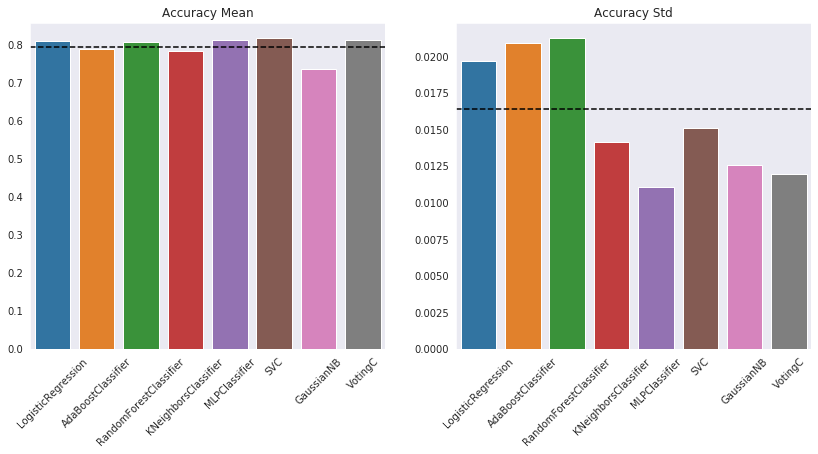

In [85]:
classifier_names=['LogisticRegression','AdaBoostClassifier','RandomForestClassifier','KNeighborsClassifier','MLPClassifier','SVC','GaussianNB', 'VotingC']
figure, ax=plt.subplots(1,2,figsize=(14,6))
g1=sns.barplot(x=classifier_names, y=list(accuracy_mean)+[np.mean(voting_cross_val_score)], ax=ax[0])
ax[0].set_title('Accuracy Mean');
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45);
ax[0].axhline(np.mean(accuracy_mean), ls='--', color='black');
g2=sns.barplot(x=classifier_names, y=list(accuracy_std)+[np.std(voting_cross_val_score)], ax=ax[1])
ax[1].set_title('Accuracy Std')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45);
ax[1].axhline(np.mean(accuracy_std), ls='--', color='black');
plt.close(2)

Podemos ver como el modelo clasificador ensamblado, no es mejor que el **Support Vector Classifier** perteneciente a los estimadores, atendiendo al valor medio de su precisión y variación estandar.

Por este motivo, a la hora de realizar las predicciones en el set de testeo, emplearemos el SVC.

Una buena opción para mejorar los resultados, sería probar nuevos algoritmos clasificadores, nuevos métodos ensamblados como **stacking** y nuevos ajustes.

Pasamos finalmente a convertir el set de testeo para poder aplicar en las predicciones el modelo generado:

In [86]:
test_df['Title']=test_df['Name'].apply(get_title_from_names)

In [87]:
test_df['Title'].replace(['Col','Major','Jonkheer','Ms','Mlle','Mme','Lady','Dona','the Countess','Sir','Capt','Don'],'RareTitle', inplace=True)

In [88]:
test_df.drop(columns=['Name'], inplace=True)

In [89]:
test_df['Age']=test_df['Age'].isnull().apply(generate_new_age)

In [90]:
test_df['Age_Gr']=test_df['Age'].apply(group_ages)


In [91]:
test_df.drop(columns=['Age'], inplace=True)

In [92]:
test_df['Tr_Alone']=test_df.apply(travels_alone, axis=1)

In [93]:
test_df.drop(columns=['SibSp', 'Parch'], inplace=True)

In [94]:
test_df['PC_inticket']=test_df['Ticket'].apply(pc_in_ticket)
test_df['WC_inticket']=test_df['Ticket'].apply(wc_in_ticket)

In [95]:
test_df.drop(columns=['Ticket'], inplace=True)

In [96]:
def identify_interval(row):
    if (int(row['Fare'])>=0) and (int(row['Fare'])<7):
        return '(-0.1, 7.0]'
    if (int(row['Fare'])>=12) and (int(row['Fare'])<19):
        return '(12.0, 19.0]'
    if (int(row['Fare'])>=56) and (int(row['Fare'])<512):
        return '(56.0, 512.0]' 
    if (int(row['Fare'])>=27) and (int(row['Fare'])<56):
        return '(27.0, 56.0]'  
    if (int(row['Fare'])>=19) and (int(row['Fare'])<27):
        return '(19.0, 27.0]'  
    if (int(row['Fare'])>=8) and (int(row['Fare'])<12):
        return '(8.0, 12.0]' 
    if (int(row['Fare'])>=7) and (int(row['Fare'])<8):
        return '(7.0, 8.0]' 

In [97]:
test_df.loc[test_df['Fare'].isnull(), 'Fare']=most_frequent_fare

In [98]:
test_df['Fare_Gr']=test_df.apply(identify_interval, axis=1)

In [99]:
test_df.loc[test_df['Embarked'].isnull(), 'Embarked']='S'

In [100]:
test_df.drop(columns=['Cabin'], inplace=True)

In [101]:
test_df = pd.get_dummies(test_df, columns=['Pclass','Embarked','Title','Fare_Gr','Sex','Age_Gr', 'Tr_Alone','WC_inticket','PC_inticket'])


In [106]:
test_df=test_df[X_train.columns]